# Backtest VWAP performance

## Imports

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
import math

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM, MultinomialHMM, GMMHMM

from dateutil.relativedelta import relativedelta
import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [3]:
plt.style.available

['Solarize_Light2',
 '_classic_test',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [4]:
## GLOBAL VARS
DATE_TIME = 'date_time'
DATE = 'date'
TIME = 'time'
OPEN_PRICE = 'open'
HIGH_PRICE = 'high'
LOW_PRICE = 'low'
CLOSE_PRICE = 'close'
VOLUME = 'volume'
TURNOVER = 'turnover'
VWAP = 'vwap'
FEATURES = ['high_low_spread', "open_close_rets", "log_total_traded_vol", "daily_log_return", "short_term_vol", "long_term_vol", "money_flow_index"]

## Functions

In [43]:
def loadData(file):
    filepath = os.path.join(DATAPATH, file)
    df = pd.read_csv("file:///" + filepath, parse_dates=[['<DTYYYYMMDD>', '<TIME>']])

    return df

def formatData(df):
    returned_df = df.copy()
    returned_df.drop(labels=["<PER>", "<OPENINT>"], axis="columns", inplace=True)
    returned_df.columns = ['date_time', 'ticker', 'open', 'high', 'low', 'close', 'volume']
    returned_df.set_index('date_time', drop=True, inplace=True)
    returned_df = addDateAndTime(returned_df)

    return returned_df

def prepareDataframe(df):
    returned_df = df.copy()
    returned_df['volume*price'] = returned_df['volume']*returned_df['close']
    returned_df = returned_df.resample('5T').sum()
    returned_df = returned_df.between_time('9:00', '17:25')
    returned_df = returned_df[returned_df.index.weekday != 5]
    returned_df = returned_df[returned_df.index.weekday != 6]
    returned_df['vwap'] = returned_df['volume*price']/returned_df['volume']

    return returned_df

def splitTrainTestData(df, size_in_years):
    training_data = df[df.index[0]:df.index[0] + relativedelta(years=size_in_years, hours=-9, minutes = -5)]
    test_data = df[df.index[0] + relativedelta(years=size_in_years, hours=-9):]

    return training_data, test_data

def getWeekdaysData(df):
    df_mondays = df[df.index.weekday == 0]
    df_tuesdays = df[df.index.weekday == 1]
    df_wednesdays = df[df.index.weekday == 2]
    df_thursdays = df[df.index.weekday == 3]
    df_fridays = df[df.index.weekday == 4]

    return df_mondays, df_tuesdays, df_wednesdays, df_thursdays, df_fridays

def getWeekdaysDataDict(df):
    weekdaysDataDict = {}
    weekdaysDataDict[0] = df[df.index.weekday == 0]
    weekdaysDataDict[1] = df[df.index.weekday == 1]
    weekdaysDataDict[2] = df[df.index.weekday == 2]
    weekdaysDataDict[3] = df[df.index.weekday == 3]
    weekdaysDataDict[4] = df[df.index.weekday == 4]
    weekdaysDataDict['else'] = df

    return weekdaysDataDict

def getStaticVolPredictorByWeekday(data, weekdaysDataDict):
    staticVolPredictor = {}
    staticVolPredictor[0] = getNormalizedStaticVolPredictor(weekdaysDataDict.get(0))
    staticVolPredictor[1] = getNormalizedStaticVolPredictor(weekdaysDataDict.get(1))
    staticVolPredictor[2] = getNormalizedStaticVolPredictor(weekdaysDataDict.get(2))
    staticVolPredictor[3] = getNormalizedStaticVolPredictor(weekdaysDataDict.get(3))
    staticVolPredictor[4] = getNormalizedStaticVolPredictor(weekdaysDataDict.get(4))
    staticVolPredictor['else'] = getNormalizedStaticVolPredictor(data)

    return staticVolPredictor

def getADVMedianByWeekday(data, weekdaysDataDict):
    advMedian = {}
    advMedian[0] = getADVMedian(weekdaysDataDict.get(0))
    advMedian[1] = getADVMedian(weekdaysDataDict.get(1))
    advMedian[2] = getADVMedian(weekdaysDataDict.get(2))
    advMedian[3] = getADVMedian(weekdaysDataDict.get(3))
    advMedian[4] = getADVMedian(weekdaysDataDict.get(4))
    advMedian['else'] = getADVMedian(data)

    return advMedian
  
def getDataByWeekDay(df, weekday):
    df_weekday = df[df.index.weekday == weekday]

    return df_weekday

def addDateAndTime(df):
    returned_df = df.copy()
    returned_df['date'] = pd.to_datetime(returned_df.index.date)
    returned_df['time'] = pd.to_datetime(returned_df.index, format = "%m-%d-%Y %H:%M:%S")
    returned_df['time'] = returned_df['time'].apply(lambda x: x.strftime('%H:%M:%S'))

    return returned_df

def getNormalizedStaticVolPredictor(df):
    df = addDateAndTime(df)

    static_volume_predictor = df.groupby(by='time')['volume'].median()
    norm_static_volume_predictor = static_volume_predictor/sum(static_volume_predictor)
    norm_static_volume_predictor.index = norm_static_volume_predictor.index.map(lambda x: datetime.strptime(x, '%X').time())

    return norm_static_volume_predictor

def getReversedCumVol(multi_data, data):
    reversed_cumvol = []
    for day in multi_data.index.get_level_values('Date').unique():
        reversed_cumvol.append(multi_data.xs(day, level='Date')['volume'].cumsum().values[::-1])

    reversed_cumvol = pd.Series(data = np.array(reversed_cumvol).flatten(), index = data.index)

    return reversed_cumvol

def getADVMedian(df):
    return df['volume'].groupby(df.index.date).sum().median()

def getADVMean(df):
    return df['volume'].groupby(df.index.date).sum().median()

def getDailyVWAP(df):
    return df['volume*price'].groupby(df.index.date).sum()/df['volume'].groupby(df.index.date).sum()
  
def getVolPredictorNextBin(test_data, staticVolPredictor, advMedian):
    volume_predictor_next_interval = test_data.groupby(level=0)['volume'].shift(1)
    volume_predictor_next_interval.fillna(int (advMedian.get('else')*staticVolPredictor.get('else').iloc[0]), inplace=True)

    return volume_predictor_next_interval
  
def vwap_static_execution_algo(data, staticVolPredictor, amount_shares, order_side, start_time, end_time, day):
    if day.weekday() == 0:
        volPredictor = staticVolPredictor.get(0)[start_time:end_time]
    elif day.weekday() == 1:
        volPredictor = staticVolPredictor.get(1)[start_time:end_time]
    elif day.weekday() == 2:
        volPredictor = staticVolPredictor.get(2)[start_time:end_time]
    elif day.weekday() == 3:
        volPredictor = staticVolPredictor.get(3)[start_time:end_time]
    elif day.weekday() == 4:
        volPredictor = staticVolPredictor.get(4)[start_time:end_time]
    else:
        volPredictor = staticVolPredictor.get('else')[start_time:end_time]

    shares_per_interval = volPredictor*amount_shares
    vwap_this_exec_this_day = sum(shares_per_interval*data['vwap'])/sum(shares_per_interval)

    return vwap_this_exec_this_day

def vwap_dynamic_execution_algo(data, reversed_cumvol, staticVolPredictor, volume_predictor_next_interval, amount_shares, order_side, start_time, end_time, day):
    shares_per_interval = []
    if day.weekday() == 0:
        shares_per_interval.append(staticVolPredictor.get(0).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 0].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 0].index.time).median()
    elif day.weekday() == 1:
        shares_per_interval.append(staticVolPredictor.get(1).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 1].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 1].index.time).median()
    elif day.weekday() == 2:
        shares_per_interval.append(staticVolPredictor.get(2).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 2].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 2].index.time).median()
    elif day.weekday() == 3:
        shares_per_interval.append(staticVolPredictor.get(3).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 3].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 3].index.time).median()
    elif day.weekday() == 4:
        shares_per_interval.append(staticVolPredictor.get(4).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 4].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 4].index.time).median()
    else:
        shares_per_interval.append(staticVolPredictor.get('else').iloc[0]*amount_shares)
        volPredictor = reversed_cumvol.groupby(reversed_cumvol.index.time).median()

    for i in range(1, len(data)):
        num = data['volume'].iloc[:i].sum()+volume_predictor_next_interval.xs(day, level='Date').iloc[i]
        denom = data['volume'].iloc[:i].sum()+volPredictor[i]
        op = amount_shares*(num/denom)
        shares_next_interval = op - sum(shares_per_interval)
        #     shares_next_interval = (amount_shares*((data['volume'].iloc[0:i].sum()+volume_predictor_next_interval.xs(day, level='Date').iloc[i])/(data['volume'].iloc[0:i].sum()+volPredictor[i])))-sum(shares_per_interval)
        shares_per_interval.append(shares_next_interval)

    vwap_this_exec_this_day = sum(shares_per_interval*data['vwap'])/sum(shares_per_interval)

    return vwap_this_exec_this_day

def dataToMultiIndex(data):
    multi_data = data.copy()
    multi_data.index = pd.MultiIndex.from_arrays([multi_data.index.date, multi_data.index.time], names=['Date','Time'])

    return multi_data

def backtestAlgoStatic(training_data, test_data, advMedian, staticVolPredictor):
    new_test_data = test_data.copy()
    new_test_data.index = pd.MultiIndex.from_arrays([new_test_data.index.date, new_test_data.index.time], names=['Date','Time'])

    backtest_sell_vwap = []
    backtest_buy_vwap = []
    
    for day in new_test_data.index.get_level_values('Date').unique():
        data = new_test_data.xs(day, level='Date')

        if day.weekday() == 0:
            amount_shares = advMedian.get(0)*0.1
        elif day.weekday() == 1:
            amount_shares = advMedian.get(1)*0.1
        elif day.weekday() == 2:
            amount_shares = advMedian.get(2)*0.1
        elif day.weekday() == 3:
            amount_shares = advMedian.get(3)*0.1
        elif day.weekday() == 4:
            amount_shares = advMedian.get(4)*0.1
        else:
            amount_shares = advMedian.get('else')*0.1

        backtest_sell_vwap.append(vwap_static_execution_algo(data, staticVolPredictor, amount_shares, 'sell' ,data.index[0], data.index[-1], day))
        backtest_buy_vwap.append(vwap_static_execution_algo(data, staticVolPredictor, amount_shares, 'buy', data.index[0], data.index[-1], day))

    return backtest_buy_vwap, backtest_sell_vwap

def backtestAlgoDynamic(training_data, test_data, advMedian, staticVolPredictor):
    new_training_data = dataToMultiIndex(training_data)
    new_test_data = dataToMultiIndex(test_data)
    reversedCumVol = getReversedCumVol(new_training_data, training_data)
    volPredictorNextBin = getVolPredictorNextBin(new_test_data, staticVolPredictor, advMedian)


    backtest_sell_vwap_dynamic = []
    backtest_buy_vwap_dynamic = []
    for day in new_test_data.index.get_level_values('Date').unique():
        data = new_test_data.xs(day, level='Date')
        if day.weekday() == 0:
            amount_shares = advMedian.get(0)*0.1
        elif day.weekday() == 1:
            amount_shares = advMedian.get(1)*0.1
        elif day.weekday() == 2:
            amount_shares = advMedian.get(2)*0.1
        elif day.weekday() == 3:
            amount_shares = advMedian.get(3)*0.1
        elif day.weekday() == 4:
            amount_shares = advMedian.get(4)*0.1
        else:
            amount_shares = advMedian.get('else')*0.1
        backtest_sell_vwap_dynamic.append(vwap_dynamic_execution_algo(data, reversedCumVol, staticVolPredictor, volPredictorNextBin, amount_shares, 'sell', data.index[0], data.index[-1], day))
        backtest_buy_vwap_dynamic.append(vwap_dynamic_execution_algo(data, reversedCumVol, staticVolPredictor, volPredictorNextBin, amount_shares, 'buy', data.index[0], data.index[-1], day))

    return backtest_buy_vwap_dynamic, backtest_sell_vwap_dynamic
  
def getAlgoPerformance(training_data, test_data, dynamic_flag):
    daily_vwap = getDailyVWAP(test_data)
    weekdaysDataDict = getWeekdaysDataDict(training_data)
    staticVolPredictor = getStaticVolPredictorByWeekday(training_data, weekdaysDataDict)
    advMedian = getADVMedianByWeekday(training_data, weekdaysDataDict)

    if dynamic_flag:
        backtest_buy_vwap, backtest_sell_vwap = backtestAlgoDynamic(training_data, test_data, advMedian, staticVolPredictor)
    else:
        backtest_buy_vwap, backtest_sell_vwap = backtestAlgoStatic(training_data, test_data, advMedian, staticVolPredictor)

    static_vwap_comparison = pd.DataFrame(data=daily_vwap.values.tolist(), index=daily_vwap.index, columns=['market_vwap'])
    static_vwap_comparison['backtest_buy_vwap'] = backtest_buy_vwap
    static_vwap_comparison['backtest_sell_vwap'] = backtest_sell_vwap

    static_vwap_comparison['diff_vwap_bps_buy'] = 1000*(static_vwap_comparison['backtest_buy_vwap']-static_vwap_comparison['market_vwap'])/static_vwap_comparison['market_vwap']
    static_vwap_comparison['diff_vwap_bps_sell'] = -1000*(static_vwap_comparison['backtest_sell_vwap']-static_vwap_comparison['market_vwap'])/static_vwap_comparison['market_vwap']

    mean_bps_diff_buys = static_vwap_comparison['diff_vwap_bps_buy'].mean()
    sd_bps_diff_buys = static_vwap_comparison['diff_vwap_bps_buy'].std()
    mean_bps_diff_sells = static_vwap_comparison['diff_vwap_bps_sell'].mean()
    sd_bps_diff_sells = static_vwap_comparison['diff_vwap_bps_sell'].std()

    percentiles_diff_vwap_sells = {'1': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.01),
                               '5': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.05),
                               '95': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.95),
                               '99': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.99)}
    percentiles_diff_vwap_buys = {'1': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.01),
                               '5': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.05),
                               '95': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.95),
                               '99': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.99)}

    return mean_bps_diff_buys, sd_bps_diff_buys, mean_bps_diff_sells, sd_bps_diff_sells, percentiles_diff_vwap_buys, percentiles_diff_vwap_sells

def printAlgoPerformance(file, ticker):
    filepath = os.path.join(DATAPATH, file)

    df = pd.read_csv("file:///" + filepath, parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
    formatted_df = formatData(df)
    formatted_df = formatted_df[formatted_df.index.year >= 2009]
    last_year = formatted_df.index.year.unique()[-2]
    algo_df = prepareDataframe(formatted_df)
    train = algo_df[algo_df.index.year < last_year]
    test = algo_df[algo_df.index.year >= last_year]

    print("Backtesting performance with static predictor...\n")
    mean_bps_diff_buys, sd_bps_diff_buys, mean_bps_diff_sells, sd_bps_diff_sells, percentiles_diff_vwap_buys, percentiles_diff_vwap_sells = getAlgoPerformance(train, test, dynamic_flag=False)
    print("The performance of the algorithm using static predictor on " + ticker + " is")
    print("Mean: ±%f\nStandard Dev: ±%f" % (np.abs(mean_bps_diff_buys), sd_bps_diff_buys))

    print("\n\n")

    print("Backtesting performance with dynamic predictor...\n")
    mean_bps_diff_buys, sd_bps_diff_buys, mean_bps_diff_sells, sd_bps_diff_sells, percentiles_diff_vwap_buys, percentiles_diff_vwap_sells = getAlgoPerformance(train, test, dynamic_flag=True)
    print("The performance of the algorithm using dynamic predictor on " + ticker + " is")
    print("Mean: ±%f\nStandard Dev: ±%f" % (np.abs(mean_bps_diff_buys), sd_bps_diff_buys))

    print("\n")
    print("Fitting Gaussian Mixture Model...")

    high_low = get_log(np.abs(get_high_low_spread(formatted_df)))
    open_close_log_rets = get_log_open_close_returns(formatted_df)
    total_traded_vol = get_log(get_total_traded_vol(formatted_df))

    features_df = pd.concat([high_low, open_close_log_rets, total_traded_vol], axis=1).dropna()
    features_df.columns = ['hl_spread', "log_return", "traded_vol"]
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    features_df = features_df.dropna()
    features_df = features_df[features_df['log_return'] != 0.0]
    features_df = features_df[features_df['hl_spread'] != 0.0]
    features_df = features_df[["traded_vol"]]
    # features_df = features_df[['hl_spread', "log_return", "traded_vol"]]

    features_df = features_df.shift(1).dropna()

    features_train = features_df[features_df.index.year < last_year]
    features_test = features_df[features_df.index.year >= last_year]

    X = features_train.values
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    # pca = PCA(n_components=.95)
    # pca.fit(X_scaled)
    # X_pca = pca.transform(X_scaled)

    gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=1000, n_init=100)
    model = gmm.fit(X_scaled)

    X = features_df.values
    X_scaled = scaler.transform(X)
    # X_pca = pca.transform(X_scaled)

    prediction_gmm = model.predict(X_scaled)
    # prediction_gmm = hmm_model.predict(X_pca)

    print("Model fitted\n\n")
    features_df['regime'] = prediction_gmm
    regime = features_df[['regime']]
    regime = regime.resample("5T").asfreq().fillna(method="ffill")

    new_df = pd.merge(algo_df, regime, left_index=True, right_index=True)
    new_df = new_df.astype({"regime":"int32"})

    train = new_df[new_df.index.year < last_year]
    test = new_df[new_df.index.year >= last_year]

    print("Backtesting performance of static predictor using segmented data...\n")
    mean_bps_diff_buys, sd_bps_diff_buys, mean_bps_diff_sells, sd_bps_diff_sells, percentiles_diff_vwap_buys, percentiles_diff_vwap_sells = getAlgoPerformanceByRegime(train, test, dynamic_flag=False, regimes=new_df['regime'].unique())
    print("The performance of the algorithm using static predictor with segmented data on " + ticker + " is")
    print("Mean: ±%f\nStandard Dev: ±%f" % (np.abs(mean_bps_diff_buys), sd_bps_diff_buys))

    print("\n\n")

    print("Backtesting performance of dynamic predictor using segmented data...\n")
    mean_bps_diff_buys, sd_bps_diff_buys, mean_bps_diff_sells, sd_bps_diff_sells, percentiles_diff_vwap_buys, percentiles_diff_vwap_sells = getAlgoPerformanceByRegime(train, test, dynamic_flag=True, regimes=new_df['regime'].unique())
    print("The performance of the algorithm using static predictor with segmented data on " + ticker + " is")
    print("Mean: ±%f\nStandard Dev: ±%f" % (np.abs(mean_bps_diff_buys), sd_bps_diff_buys))

def vwap_static_execution_algo(data, staticVolPredictor, amount_shares, order_side, start_time, end_time, day):
    if day.weekday() == 0:
        volPredictor = staticVolPredictor.get(0)[start_time:end_time]
    elif day.weekday() == 1:
        volPredictor = staticVolPredictor.get(1)[start_time:end_time]
    elif day.weekday() == 2:
        volPredictor = staticVolPredictor.get(2)[start_time:end_time]
    elif day.weekday() == 3:
        volPredictor = staticVolPredictor.get(3)[start_time:end_time]
    elif day.weekday() == 4:
        volPredictor = staticVolPredictor.get(4)[start_time:end_time]
    else:
        volPredictor = staticVolPredictor.get('else')[start_time:end_time]

    shares_per_interval = volPredictor*amount_shares
    vwap_this_exec_this_day = sum(shares_per_interval*data['vwap'])/sum(shares_per_interval)

    return vwap_this_exec_this_day

def vwap_dynamic_execution_algo(data, reversed_cumvol, staticVolPredictor, volume_predictor_next_interval, amount_shares, order_side, start_time, end_time, day):
    shares_per_interval = []
    if day.weekday() == 0:
        shares_per_interval.append(staticVolPredictor.get(0).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 0].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 0].index.time).median()
    elif day.weekday() == 1:
        shares_per_interval.append(staticVolPredictor.get(1).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 1].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 1].index.time).median()
    elif day.weekday() == 2:
        shares_per_interval.append(staticVolPredictor.get(2).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 2].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 2].index.time).median()
    elif day.weekday() == 3:
        shares_per_interval.append(staticVolPredictor.get(3).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 3].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 3].index.time).median()
    elif day.weekday() == 4:
        shares_per_interval.append(staticVolPredictor.get(4).iloc[0]*amount_shares)
        volPredictor = reversed_cumvol[reversed_cumvol.index.weekday == 4].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 4].index.time).median()
    else:
        shares_per_interval.append(staticVolPredictor.get('else').iloc[0]*amount_shares)
        volPredictor = reversed_cumvol.groupby(reversed_cumvol.index.time).median()

    for i in range(1, len(data)):
        num = data['volume'].iloc[:i].sum()+volume_predictor_next_interval.xs(day, level='Date').iloc[i]
        denom = data['volume'].iloc[:i].sum()+volPredictor[i]
        op = amount_shares*(num/denom)
        shares_next_interval = op - sum(shares_per_interval)
        shares_per_interval.append(shares_next_interval)

    vwap_this_exec_this_day = sum(shares_per_interval*data['vwap'])/sum(shares_per_interval)

    return vwap_this_exec_this_day

def backtestAlgoStaticByRegime(training_data, test_data, advMedian, staticVolPredictor):
    new_test_data = test_data.copy()
    new_test_data.index = pd.MultiIndex.from_arrays([new_test_data.index.date,
                                                   new_test_data.index.time],
                                                   names=['Date','Time'])

    backtest_sell_vwap = []
    backtest_buy_vwap = []
    
    for day in new_test_data.index.get_level_values('Date').unique():
        data = new_test_data.xs(day, level='Date')
        regime = data['regime'].iloc[0]
        if day.weekday() == 0:
            amount_shares = advMedian.get(regime).get(0)*0.1
        elif day.weekday() == 1:
            amount_shares = advMedian.get(regime).get(1)*0.1
        elif day.weekday() == 2:
            amount_shares = advMedian.get(regime).get(2)*0.1
        elif day.weekday() == 3:
            amount_shares = advMedian.get(regime).get(3)*0.1
        elif day.weekday() == 4:
            amount_shares = advMedian.get(regime).get(4)*0.1
        else:
            amount_shares = advMedian.get(regime).get('else')*0.1
        
    backtest_sell_vwap.append(vwap_static_execution_algo(data,
                                                         staticVolPredictor.get(regime),
                                                         amount_shares,
                                                         'sell',
                                                         data.index[0],
                                                         data.index[-1],
                                                         day))
    backtest_buy_vwap.append(vwap_static_execution_algo(data,
                                                        staticVolPredictor.get(regime),
                                                        amount_shares,
                                                        'buy',
                                                        data.index[0],
                                                        data.index[-1],
                                                        day))

    return backtest_buy_vwap, backtest_sell_vwap

def backtestAlgoDynamicByRegime(training_data, test_data, advMedian, staticVolPredictor, regimes):
    new_training_data = dataToMultiIndex(training_data)
    new_test_data = dataToMultiIndex(test_data)
    regime_reversedCumVol = {}
    regime_volPredictorNextBin = {}
    for regime in regimes:
        regime_reversedCumVol[regime] = getReversedCumVol(new_training_data[new_training_data['regime']==regime], 
                                                  training_data[training_data['regime']==regime])
        regime_volPredictorNextBin[regime] = getVolPredictorNextBin(new_test_data[new_test_data['regime']==regime], 
                                                                    staticVolPredictor.get(regime),
                                                                    advMedian.get(regime))

    backtest_sell_vwap_dynamic = []
    backtest_buy_vwap_dynamic = []
    for day in new_test_data.index.get_level_values('Date').unique():
        data = new_test_data.xs(day, level='Date')
        regime = data['regime'].iloc[0]
        if day.weekday() == 0:
            amount_shares = advMedian.get(regime).get(0)*0.1
        elif day.weekday() == 1:
            amount_shares = advMedian.get(regime).get(1)*0.1
        elif day.weekday() == 2:
            amount_shares = advMedian.get(regime).get(2)*0.1
        elif day.weekday() == 3:
            amount_shares = advMedian.get(regime).get(3)*0.1
        elif day.weekday() == 4:
            amount_shares = advMedian.get(regime).get(4)*0.1
        else:
            amount_shares = advMedian.get(regime).get('else')*0.1
            
        backtest_sell_vwap_dynamic.append(vwap_dynamic_execution_algo(data, 
                                                                      regime_reversedCumVol.get(regime),
                                                                      staticVolPredictor.get(regime),
                                                                      regime_volPredictorNextBin.get(regime),
                                                                      amount_shares, 
                                                                      'sell',
                                                                      data.index[0],
                                                                      data.index[-1], day))
        backtest_buy_vwap_dynamic.append(vwap_dynamic_execution_algo(data,
                                                                     regime_reversedCumVol.get(regime),
                                                                     staticVolPredictor.get(regime),
                                                                     regime_volPredictorNextBin.get(regime),
                                                                     amount_shares,
                                                                     'buy',
                                                                     data.index[0],
                                                                     data.index[-1],
                                                                     day))

    return backtest_buy_vwap_dynamic, backtest_sell_vwap_dynamic

def getAlgoPerformanceByRegime(training_data, test_data, dynamic_flag, regimes):
    regime_daily_vwap = {}
    regime_weekdaysDataDict = {}
    regime_staticVolPredictor = {}
    regime_advMedian = {}
    daily_vwap = getDailyVWAP(test_data)
    for regime in regimes:
        regime_daily_vwap[regime] = getDailyVWAP(test_data[test_data['regime'] == regime])
        regime_weekdaysDataDict[regime] = getWeekdaysDataDict(training_data[training_data['regime'] == regime])
        regime_staticVolPredictor[regime] = getStaticVolPredictorByWeekday(training_data[training_data['regime'] == regime], regime_weekdaysDataDict[regime])
        regime_advMedian[regime] = getADVMedianByWeekday(training_data[training_data['regime'] == regime], regime_weekdaysDataDict[regime])

    if dynamic_flag:
        backtest_buy_vwap, backtest_sell_vwap = backtestAlgoDynamicByRegime(training_data, test_data, regime_advMedian, regime_staticVolPredictor, regimes)
    else:
        backtest_buy_vwap, backtest_sell_vwap = backtestAlgoStaticByRegime(training_data, test_data, regime_advMedian, regime_staticVolPredictor)

    static_vwap_comparison = pd.DataFrame(data=daily_vwap.values.tolist(), index=daily_vwap.index, columns=['market_vwap'])
    static_vwap_comparison['backtest_buy_vwap'] = backtest_buy_vwap
    static_vwap_comparison['backtest_sell_vwap'] = backtest_sell_vwap

    static_vwap_comparison['diff_vwap_bps_buy'] = 1000*(static_vwap_comparison['backtest_buy_vwap']-static_vwap_comparison['market_vwap'])/static_vwap_comparison['market_vwap']
    static_vwap_comparison['diff_vwap_bps_sell'] = -1000*(static_vwap_comparison['backtest_sell_vwap']-static_vwap_comparison['market_vwap'])/static_vwap_comparison['market_vwap']

    mean_bps_diff_buys = static_vwap_comparison['diff_vwap_bps_buy'].mean()
    sd_bps_diff_buys = static_vwap_comparison['diff_vwap_bps_buy'].std()
    mean_bps_diff_sells = static_vwap_comparison['diff_vwap_bps_sell'].mean()
    sd_bps_diff_sells = static_vwap_comparison['diff_vwap_bps_sell'].std()

    percentiles_diff_vwap_sells = {'1': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.01),
                               '5': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.05),
                               '95': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.95),
                               '99': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.99)}
    percentiles_diff_vwap_buys = {'1': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.01),
                               '5': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.05),
                               '95': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.95),
                               '99': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.99)}

    return mean_bps_diff_buys, sd_bps_diff_buys, mean_bps_diff_sells, sd_bps_diff_sells, percentiles_diff_vwap_buys, percentiles_diff_vwap_sells

def get_total_traded_vol(df):
    total_traded_vol = df.resample('B').sum()[['volume']]
    total_traded_vol.drop(labels=total_traded_vol.index.get_values()[0], axis='index', inplace=True)

    return total_traded_vol

def get_log_open_close_returns_(df):
    # open_close_returns = df[(df['time'] == '09:01:00') | (df['time'] == '17:35:00')]
    open_close_returns = df[(df['time'] == '09:00:00') | (df['time'] == '17:35:00')]
    open_close_returns['return'] = (open_close_returns['open']/open_close_returns['close'].shift(-1))
    open_close_returns['log_return'] = np.log(open_close_returns['return'])
    # open_close_returns = open_close_returns[open_close_returns['time'] == '09:01:00']
    open_close_returns = open_close_returns[open_close_returns['time'] == '09:00:00']
    open_close_returns = open_close_returns[['log_return']].resample('B').sum()

    return open_close_returns

def get_log_open_close_returns(df):
    open_price = df[OPEN_PRICE].resample('B').first()
    close_price = df[CLOSE_PRICE].resample('B').last()
    open_close_returns = np.log(open_price/close_price.shift(-1)).dropna()

    return open_close_returns

def get_log_returns(df):
    close = df[CLOSE_PRICE].resample('B').last()
    log_daily_returns = np.log(close/close.shift(-1))

    return log_daily_returns

def get_high_low_spread(df):
    daily_high = df.resample("B").max()[['high']]
    daily_low = df.resample("B").min()[['low']]
    high_low_spread = (daily_high['high']-daily_low['low'])

    return high_low_spread

def get_log(df):
    return np.log(df)

def getFeaturesDf(df):
    high_low = get_log(np.abs(get_high_low_spread(df)))
    open_close_log_rets = get_log_open_close_returns(df)
    total_traded_vol = get_log(get_total_traded_vol(df))

    features_df = pd.concat([high_low, open_close_log_rets, total_traded_vol], axis=1).dropna()
    features_df.columns = ['hl_spread', "log_return", "traded_vol"]
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    features_df = features_df.dropna()
    features_df = features_df[features_df['log_return'] != 0.0]
    features_df = features_df[features_df['hl_spread'] != 0.0]

    return features_df

def processDataToFit(features_df):
    X = features_df.values
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    pca = PCA(n_components=.95)
    pca.fit(X)
    X_pca = pca.transform(X)

    return X_pca

def fit_model(model, full_data, train_data, list_of_features):
    X = train_data.values
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    if len(list_of_features) > 2:
        pca = PCA(n_components=.95)
        pca.fit(X_scaled)
        X_pca = pca.transform(X_scaled)
        fitted_model = model.fit(X_pca)
        X_full = full_data.values
        X_full_scaled = scaler.transform(X_full)
        X_full_pca = pca.transform(X_full_scaled)
        prediction = fitted_model.predict(X_full_pca)
    else:
        fitted_model = model.fit(X_scaled)
        X_full = full_data.values
        X_full_scaled = scaler.transform(X_full)
        prediction = fitted_model.predict(X_full_scaled)

    return prediction

def get_money_flow_index(df):
    close = df[CLOSE_PRICE].resample('B').last()
    high = df[HIGH_PRICE].resample('B').max()
    low = df[LOW_PRICE].resample('B').min()
    typical_price = (close+high+low)/3
    volume = df[VOLUME].resample('B').sum()
    money_flow_index = typical_price/volume

    return money_flow_index

In [6]:
warnings.filterwarnings("ignore")
DATAPATH = os.getcwd()[:-4]+"Data\\"
filepath_anon = os.path.join(DATAPATH, "volume_price_2014_18.csv")

## EDA

In [22]:
files_list = []
for root, dirs, files in os.walk(DATAPATH):
    for file in files:
        files_list.append(file)

In [23]:
files_list

['AAPL.txt',
 'AIR_AIRBUS.txt',
 'BBVA_MC.txt',
 'BMW_BMW.txt',
 'BOEING.txt',
 'COMMERZBANK.txt',
 'DIAGEO.txt',
 'E-MINI SP 500.txt',
 'ENGIE.txt',
 'EURO BOBL.txt',
 'EURO BUND.txt',
 'FTSE 100.txt',
 'GENERAL ELECTRIC.txt',
 'GILEAD.txt',
 'GSK.txt',
 'IBERDROLA.txt',
 'MELIA.txt',
 'MSFT.txt',
 'NESTLE.txt',
 'NOKIA.txt',
 'REE.txt',
 'SOCGEN.txt',
 'T-MOBILE.txt',
 'TEF.txt',
 'TESCO.txt',
 'VIVENDI.txt',
 'WALMART.txt']

In [44]:
df = pd.read_csv("file:///" + os.path.join(DATAPATH, files_list[0]), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])

In [45]:
df = formatData(df)

In [47]:
open_time = df.time.min()
last_time = df.time.max()
close_time = df[apple[TIME] != apple.time.max()].time.max()

In [48]:
df[TURNOVER] = apple[VOLUME]*apple[CLOSE_PRICE]

In [49]:
df_resampled = df.resample('5T').sum()

In [50]:
df_resampled = df_resampled[(df_resampled.index.weekday != 5) | (df_resampled.index.weekday != 6)]

In [51]:
df_resampled[VWAP] = df_resampled[TURNOVER]/df_resampled[VOLUME]

In [52]:
daily_vwap = df_resampled[TURNOVER].groupby(df_resampled.index.date).sum()/df_resampled[VOLUME].groupby(df_resampled.index.date).sum()

In [126]:
training_data = df_resampled[df_resampled.index[0]:df_resampled.index[-1] - relativedelta(years=2, hours=-9, minutes = -5)]
test_data = df_resampled[df_resampled.index[-1] - relativedelta(years=2, hours=-9):]
daily_vwap_train = daily_vwap[training_data.index.date[0]:training_data.index.date[-1]]
daily_vwap_test = daily_vwap[test_data.index.date[0]:test_data.index.date[-1]]

In [127]:
total_volume_daily = training_data['volume'].groupby(training_data.index.date).sum()

In [128]:
training_data_mondays = training_data[training_data.index.weekday == 0]
training_data_tuesdays = training_data[training_data.index.weekday == 1]
training_data_wednesdays = training_data[training_data.index.weekday == 2]
training_data_thursdays = training_data[training_data.index.weekday == 3]
training_data_fridays = training_data[training_data.index.weekday == 4]

**Volume curve no weekdays**

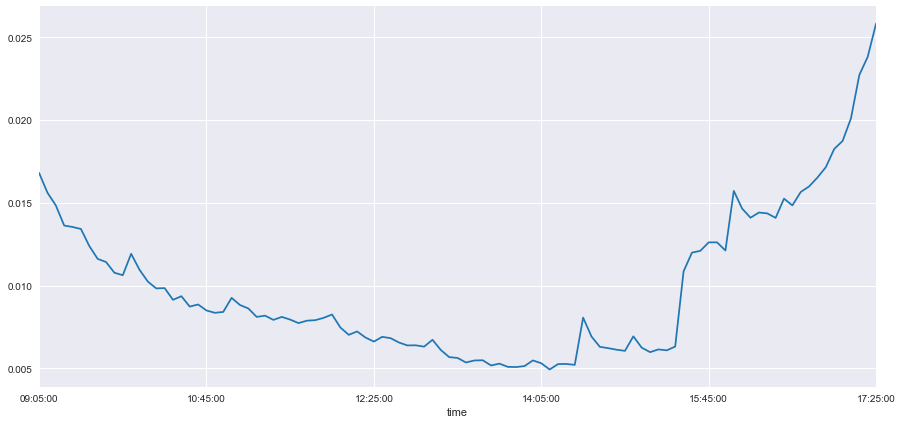

In [129]:
training_data['date'] = pd.to_datetime(training_data.index.date)
training_data['time'] = pd.to_datetime(training_data.index, format = "%m-%d-%Y %H:%M:%S")
training_data['time'] = training_data['time'].apply(lambda x: x.strftime('%H:%M:%S'))
training_data = training_data.between_time(open_time, close_time)

static_volume_predictor = training_data.groupby(by='time')['volume'].median()
norm_static_volume_predictor = static_volume_predictor/sum(static_volume_predictor)

plt.figure(figsize=(15,7))
norm_static_volume_predictor.plot()
plt.show()

**Volume curve per weekday**

In [130]:
training_data_mondays['date'] = pd.to_datetime(training_data_mondays.index.date)
training_data_mondays['time'] = pd.to_datetime(training_data_mondays.index, format = "%m-%d-%Y %H:%M:%S")
training_data_mondays['time'] = training_data_mondays['time'].apply(lambda x: x.strftime('%H:%M:%S'))
training_data_mondays = training_data_mondays.between_time(open_time, close_time)

training_data_tuesdays['date'] = pd.to_datetime(training_data_tuesdays.index.date)
training_data_tuesdays['time'] = pd.to_datetime(training_data_tuesdays.index, format = "%m-%d-%Y %H:%M:%S")
training_data_tuesdays['time'] = training_data_tuesdays['time'].apply(lambda x: x.strftime('%H:%M:%S'))
training_data_tuesdays = training_data_tuesdays.between_time(open_time, close_time)

training_data_wednesdays['date'] = pd.to_datetime(training_data_wednesdays.index.date)
training_data_wednesdays['time'] = pd.to_datetime(training_data_wednesdays.index, format = "%m-%d-%Y %H:%M:%S")
training_data_wednesdays['time'] = training_data_wednesdays['time'].apply(lambda x: x.strftime('%H:%M:%S'))
training_data_wednesdays = training_data_wednesdays.between_time(open_time, close_time)

training_data_thursdays['date'] = pd.to_datetime(training_data_thursdays.index.date)
training_data_thursdays['time'] = pd.to_datetime(training_data_thursdays.index, format = "%m-%d-%Y %H:%M:%S")
training_data_thursdays['time'] = training_data_thursdays['time'].apply(lambda x: x.strftime('%H:%M:%S'))
training_data_thursdays = training_data_thursdays.between_time(open_time, close_time)

training_data_fridays['date'] = pd.to_datetime(training_data_fridays.index.date)
training_data_fridays['time'] = pd.to_datetime(training_data_fridays.index, format = "%m-%d-%Y %H:%M:%S")
training_data_fridays['time'] = training_data_fridays['time'].apply(lambda x: x.strftime('%H:%M:%S'))
training_data_fridays = training_data_fridays.between_time(open_time, close_time)

In [131]:
static_volume_predictor_mondays = training_data_mondays.groupby(by='time')['volume'].median()
norm_static_volume_predictor_mondays = static_volume_predictor_mondays/sum(static_volume_predictor_mondays)
norm_static_volume_predictor_mondays.index = norm_static_volume_predictor_mondays.index.map(lambda x: datetime.strptime(x, '%X').time())
# static_volume_predictor_mondays.index = static_volume_predictor_mondays.index.time
# static_volume_predictor_mondays.index = pd.to_datetime(static_volume_predictor_mondays.index, format="%H:%M:%S")
# static_volume_predictor_mondays.set_index(pd.date_range(start=datetime.strftime("9:00:00"), end=datetime.strftime("16:25:00"), freq='5T'))
# static_volume_predictor_mondays.index = pd.date_range(start=datetime.strptime('9:00:00', '%X'), end=datetime.strptime('17:25:00', '%X'), freq='5T')

static_volume_predictor_tuesdays = training_data_tuesdays.groupby(by='time')['volume'].median()
norm_static_volume_predictor_tuesdays = static_volume_predictor_tuesdays/sum(static_volume_predictor_tuesdays)
norm_static_volume_predictor_tuesdays.index = norm_static_volume_predictor_tuesdays.index.map(lambda x: datetime.strptime(x, '%X').time())
# static_volume_predictor_tuesdays.index = pd.to_datetime(static_volume_predictor_tuesdays.index, format="%H:%M:%S")

static_volume_predictor_wednesdays = training_data_wednesdays.groupby(by='time')['volume'].median()
norm_static_volume_predictor_wednesdays = static_volume_predictor_wednesdays/sum(static_volume_predictor_wednesdays)
norm_static_volume_predictor_wednesdays.index = norm_static_volume_predictor_wednesdays.index.map(lambda x: datetime.strptime(x, '%X').time())
# static_volume_predictor_wednesdays.index = pd.to_datetime(static_volume_predictor_wednesdays.index, format="%H:%M:%S")

static_volume_predictor_thursdays = training_data_thursdays.groupby(by='time')['volume'].median()
norm_static_volume_predictor_thursdays = static_volume_predictor_thursdays/sum(static_volume_predictor_thursdays)
norm_static_volume_predictor_thursdays.index = norm_static_volume_predictor_thursdays.index.map(lambda x: datetime.strptime(x, '%X').time())
# static_volume_predictor_thursdays.index = pd.to_datetime(static_volume_predictor_thursdays.index, format="%H:%M:%S")

static_volume_predictor_fridays = training_data_fridays.groupby(by='time')['volume'].median()
norm_static_volume_predictor_fridays = static_volume_predictor_fridays/sum(static_volume_predictor_fridays)
norm_static_volume_predictor_fridays.index = norm_static_volume_predictor_fridays.index.map(lambda x: datetime.strptime(x, '%X').time())
# static_volume_predictor_fridays.index = pd.to_datetime(static_volume_predictor_fridays.index, format="%H:%M:%S")

In [132]:
norm_static_volume_predictor.index = norm_static_volume_predictor.index.map(lambda x: datetime.strptime(x, '%X').time())

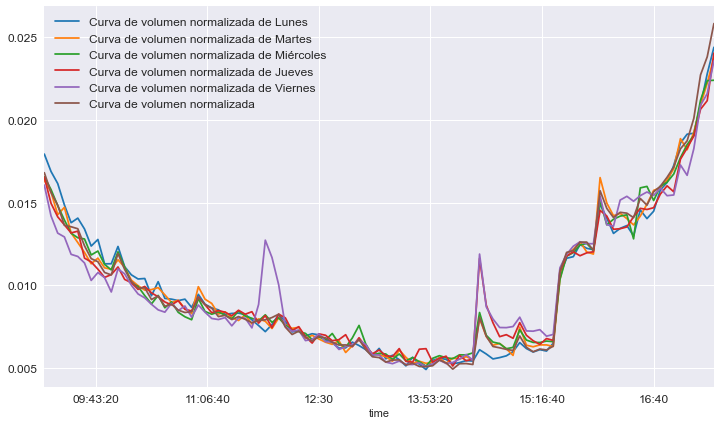

In [150]:
plt.figure(figsize=(12, 7))
norm_static_volume_predictor_mondays.plot(label="Curva de volumen normalizada de Lunes")
norm_static_volume_predictor_tuesdays.plot(label="Curva de volumen normalizada de Martes")
norm_static_volume_predictor_wednesdays.plot(label="Curva de volumen normalizada de Miércoles")
norm_static_volume_predictor_thursdays.plot(label="Curva de volumen normalizada de Jueves")
norm_static_volume_predictor_fridays.plot(label="Curva de volumen normalizada de Viernes")
norm_static_volume_predictor.plot(label="Curva de volumen normalizada")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=2, prop={'size': 12})
plt.show()